
# 🧠 Building Perceptron — Notebook principal

**Objectif** : 
---
Ce projet s'inscrit dans le cadre d'une initiation au Deep Learning à La Plateforme_. Il vise à comprendre et implémenter le Perceptron, le premier neurone artificiel inventé par Frank Rosenblatt, considéré comme la pierre angulaire de l'apprentissage automatique moderne.

L'objectif principal est de développer une compréhension approfondie des concepts fondamentaux du Machine Learning à travers l'implémentation d'un Perceptron en Python, puis de tester ce modèle sur un cas d'usage réel avec le dataset Breast Cancer Wisconsin.

---



## Sommaire
1. [Imports & configuration](#imports)
2. [Chargement des données (Breast Cancer Wisconsin)](#data)
3. [Analyse exploratoire (EDA)](#eda)
4. [Prétraitement & features](#preproc)
5. [Réduction de dimension (PCA)](#pca)
6. [Implémentation / Import de la classe `Perceptron` (OO)](#class)
7. [Baselines & Pipeline Scikit-learn](#pipeline)
8. [Entraînement, Métriques & Visualisations](#metrics)
9. [Validation croisée & courbes ROC/PR](#cv)
10. [Sauvegardes (modèle, figures)](#save)
11. [Robustesse & tests complémentaires](#robust)
12. [Conclusion & limites](#conclusion)
13. [Références](#refs)


## 1. Imports & configuration <a id='imports'></a>

In [78]:
# Installation des dépendances :  pip install -r requirements.txt
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.subplots as sp

# Scikit-learn
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, PowerTransformer, RobustScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.pipeline import Pipeline
from boruta import BorutaPy
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score,
    roc_curve, precision_recall_curve, average_precision_score, balanced_accuracy_score
)

warnings.filterwarnings('ignore') # Ignore warnings for cleaner output
sns.set_theme() # Set Seaborn theme for plots
RANDOM_STATE = 42 # Pour reproductibilité
np.random.seed(RANDOM_STATE) # Seed global NumPy

import sys
import os

# Ajoute le dossier racine à sys.path (où se trouve 'src/')
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)
    
from src.models.PerceptronCustom import Perceptron
from src.models.perceptron_earlystopping import PerceptronEarlyStopping




### Paramètres globaux & répertoires

## 2. Chargement des données 

In [2]:
bcw_df = pd.read_csv("../data/bcw_data.csv")
bcw_df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [3]:
bcw_df.shape # Les dimensions du dataset

(569, 33)

---

## 📌 Description du dataset — Breast Cancer Wisconsin

Ce dataset contient les mesures issues d’images numérisées de masses mammaires.

- **Colonne 1** : `ID number`
- **Colonne 2** : `Diagnosis` — M (malin), B (bénin)
- **Colonnes 3 à 32** : 30 variables numériques extraites des images :

Pour chaque noyau de cellule, **10 caractéristiques réelles** sont calculées :

- a) `radius` — moyenne des distances du centre au périmètre  
- b) `texture` — écart-type des niveaux de gris  
- c) `perimeter` — périmètre de la cellule  
- d) `area` — aire  
- e) `smoothness` — variation locale des longueurs de rayon  
- f) `compactness` — (périmètre² / aire - 1.0)  
- g) `concavity` — sévérité des portions concaves  
- h) `concave points` — nombre de zones concaves  
- i) `symmetry` — symétrie de la forme  
- j) `fractal dimension` — approximation de type “ligne de côte”  

Chacune de ces 10 caractéristiques est déclinée en moyenne, erreur standard, et valeur "worst" (max), soit 30 colonnes au total.

## 3. Analyse exploratoire (EDA) <a id='eda'></a>

In [4]:
print("\nInfos:") # Info sur le DataFrame
bcw_df.info()


Infos:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se      

In [5]:
def detecter_valeurs_manquantes(df):
    """detecter_valeurs_manquantes : détecte les valeurs manquantes dans un DataFrame pandas

    Args:
        df: DataFrame pandas

    Returns:
        tableau avec le nombre et pourcentage de valeurs manquantes par colonne
    """
    
    # Remplace les chaînes vides ou espaces par NaN
    df_clean = df.replace(r'^\s*$', np.nan, regex=True)
    
    # Nombre et pourcentage
    missing = df_clean.isna().sum().to_frame("nb_valeurs_manquantes")
    missing["pourcentage"] = (missing["nb_valeurs_manquantes"] / len(df_clean) * 100).round(2)
    
    return missing.sort_values("nb_valeurs_manquantes", ascending=False)


In [6]:
detecter_valeurs_manquantes(bcw_df)

,nb_valeurs_manquantes,pourcentage
Unnamed: 32,569,100.0
compactness_se,0,0.0
fractal_dimension_worst,0,0.0
symmetry_worst,0,0.0
concave points_worst,0,0.0
concavity_worst,0,0.0
compactness_worst,0,0.0
smoothness_worst,0,0.0
area_worst,0,0.0
perimeter_worst,0,0.0


>**Note** : La feature 'Unnamed: 32' est vide donc on va la supprimer.

In [7]:
bcw_df = bcw_df.drop(columns=["Unnamed: 32", "id"]) # Suppression de la colonne vide et de l'id

In [8]:
def detecter_doublons(df, subset=None):
    """
    Détecte les doublons dans un DataFrame.
    
    Paramètres
    ----------
    df : pd.DataFrame
        Le DataFrame à analyser
    subset : list ou None
        Colonnes sur lesquelles vérifier les doublons (par défaut toutes les colonnes)
   
    """
    return df[df.duplicated(subset=subset, keep=False)].sort_values(by=subset if subset else df.columns.tolist())


In [9]:
detecter_doublons(bcw_df)

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst


> **Note** : Pas de doublon dans ce dataset

In [10]:
bcw_df['diagnosis'] = bcw_df['diagnosis'].map({'M': 1, 'B': 0}) # Encodage de la cible: 1 pour Malin, 0 pour Bénin


In [11]:
display(bcw_df.describe().T) # Statistiques descriptives

,count,mean,std,min,25%,50%,75%,max
diagnosis,569.0,0.372583,0.483918,0.000000,0.000000,0.000000,1.000000,1.00000
radius_mean,569.0,14.127292,3.524049,6.981000,11.700000,13.370000,15.780000,28.11000
texture_mean,569.0,19.289649,4.301036,9.710000,16.170000,18.840000,21.800000,39.28000
perimeter_mean,569.0,91.969033,24.298981,43.790000,75.170000,86.240000,104.100000,188.50000
area_mean,569.0,654.889104,351.914129,143.500000,420.300000,551.100000,782.700000,2501.00000
smoothness_mean,569.0,0.096360,0.014064,0.052630,0.086370,0.095870,0.105300,0.16340
compactness_mean,569.0,0.104341,0.052813,0.019380,0.064920,0.092630,0.130400,0.34540
concavity_mean,569.0,0.088799,0.079720,0.000000,0.029560,0.061540,0.130700,0.42680
concave points_mean,569.0,0.048919,0.038803,0.000000,0.020310,0.033500,0.074000,0.20120
symmetry_mean,569.0,0.181162,0.027414,0.106000,0.161900,0.179200,0.195700,0.30400


In [12]:
# Les valeurs Manquantes
missing = bcw_df.isna().sum().sort_values(ascending=False)
display(missing[missing > 0])

Series([], dtype: int64)

In [13]:
X = bcw_df.drop(columns=['diagnosis'])  # Features  
y = bcw_df["diagnosis"]  # Target

In [14]:
feature_names = X.columns.tolist() # Liste des noms de features
feature_names

['radius_mean',
 'texture_mean',
 'perimeter_mean',
 'area_mean',
 'smoothness_mean',
 'compactness_mean',
 'concavity_mean',
 'concave points_mean',
 'symmetry_mean',
 'fractal_dimension_mean',
 'radius_se',
 'texture_se',
 'perimeter_se',
 'area_se',
 'smoothness_se',
 'compactness_se',
 'concavity_se',
 'concave points_se',
 'symmetry_se',
 'fractal_dimension_se',
 'radius_worst',
 'texture_worst',
 'perimeter_worst',
 'area_worst',
 'smoothness_worst',
 'compactness_worst',
 'concavity_worst',
 'concave points_worst',
 'symmetry_worst',
 'fractal_dimension_worst']

In [15]:
y.value_counts()

diagnosis
0    357
1    212
Name: count, dtype: int64

**Interprétation**

- Il y a un **déséquilibre modéré** entre les deux classes.
- Ce n’est pas un cas d’**extrême imbalance**, mais il faut **éviter de se baser uniquement sur l’accuracy** pour évaluer un modèle.
- Il est **recommandé** d’utiliser plusieurs métriques :

  - **F1-score** : équilibre précision / rappel
  - **Recall** (sensibilité) pour la classe 0 (*malignant*) : très importante en détection de cancer
  - **ROC AUC** ou **Courbe Précision/Rappel**

In [16]:
# Split stratifié train/test (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,              # 20% des données pour test
    stratify=y,                 # garde même proportion M/B dans train et test
    random_state=42             # pour reproductibilité
)

In [17]:
X_train

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
10,16.02,23.24,102.70,797.8,0.08206,0.06669,0.03299,0.03323,0.1528,0.05697,...,19.19,33.88,123.80,1150.0,0.11810,0.15510,0.14590,0.09975,0.2948,0.08452
170,12.32,12.39,78.85,464.1,0.10280,0.06981,0.03987,0.03700,0.1959,0.05955,...,13.50,15.64,86.97,549.1,0.13850,0.12660,0.12420,0.09391,0.2827,0.06771
407,12.85,21.37,82.63,514.5,0.07551,0.08316,0.06126,0.01867,0.1580,0.06114,...,14.40,27.01,91.63,645.8,0.09402,0.19360,0.18380,0.05601,0.2488,0.08151
430,14.90,22.53,102.10,685.0,0.09947,0.22250,0.27330,0.09711,0.2041,0.06898,...,16.35,27.57,125.40,832.7,0.14190,0.70900,0.90190,0.24750,0.2866,0.11550
27,18.61,20.25,122.10,1094.0,0.09440,0.10660,0.14900,0.07731,0.1697,0.05699,...,21.31,27.26,139.90,1403.0,0.13380,0.21170,0.34460,0.14900,0.2341,0.07421
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37,13.03,18.42,82.61,523.8,0.08983,0.03766,0.02562,0.02923,0.1467,0.05863,...,13.30,22.81,84.46,545.9,0.09701,0.04619,0.04833,0.05013,0.1987,0.06169
415,11.89,21.17,76.39,433.8,0.09773,0.08120,0.02555,0.02179,0.2019,0.06290,...,13.05,27.21,85.09,522.9,0.14260,0.21870,0.11640,0.08263,0.3075,0.07351
458,13.00,25.13,82.61,520.2,0.08369,0.05073,0.01206,0.01762,0.1667,0.05449,...,14.34,31.88,91.06,628.5,0.12180,0.10930,0.04462,0.05921,0.2306,0.06291
476,14.20,20.53,92.41,618.4,0.08931,0.11080,0.05063,0.03058,0.1506,0.06009,...,16.45,27.26,112.10,828.5,0.11530,0.34290,0.25120,0.13390,0.2534,0.07858


### Matrice de corrélation

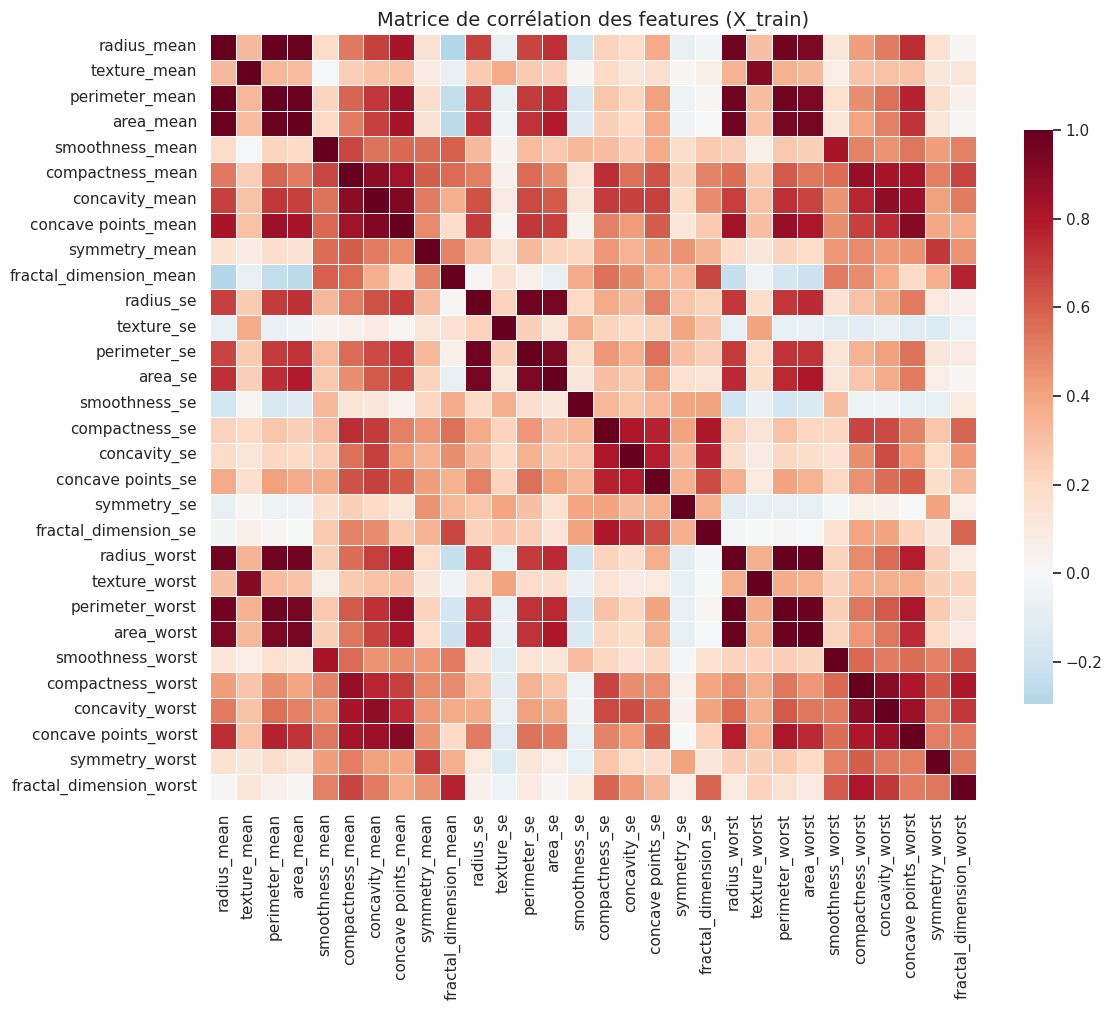

In [18]:
# 1. Calcul de la matrice de corrélation (sur X_train brut, non scalé)
corr_matrix = X_train.corr()

# 2. Affichage en heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap='RdBu_r', center=0,
            annot=False, fmt=".2f", square=True,
            linewidths=0.5, cbar_kws={"shrink": 0.75})
plt.title("Matrice de corrélation des features (X_train)", fontsize=14)
plt.tight_layout()
plt.show()

**Interprétation de la matrice de corrélation**

- Plusieurs groupes de variables présentent une **corrélation très forte** (> 0.95), ce qui suggère de la **redondance d'information**.
- Notamment :
  - `radius_mean`, `perimeter_mean`, `area_mean` sont fortement corrélées → on peut **en garder une seule**.
  - `concavity_mean`, `concave points_mean`, `compactness_mean` sont également redondantes.
  - Idem pour les variables `*_worst` (surtout `perimeter_worst`, `area_worst`, `radius_worst`).

**Conséquences :**
- Ces corrélations trop fortes peuvent nuire :
  - À la **PCA** (elles dominent les composantes principales)
  - Aux modèles linéaires comme le **Perceptron** (instabilité, surapprentissage)

**Étape suivante :**
- Supprimer les variables les plus corrélées **au-delà de 0.95** avant de passer au **scaling** ou à la **sélection par Boruta**.


In [19]:
# Top 10 des corrélations absolues
corr_pairs = corr_matrix.abs().unstack().round(3).sort_values(ascending=False)
corr_pairs = corr_pairs[corr_pairs < 1]  # exclut les 1.0 diagonaux
corr_pairs.head(10)


radius_mean      perimeter_mean     0.998
perimeter_mean   radius_mean        0.998
perimeter_worst  radius_worst       0.994
radius_worst     perimeter_worst    0.994
area_mean        radius_mean        0.987
radius_mean      area_mean          0.987
area_mean        perimeter_mean     0.986
perimeter_mean   area_mean          0.986
area_worst       radius_worst       0.983
radius_worst     area_worst         0.983
dtype: float64

In [20]:
# Matrice triangulaire supérieure pour éviter doublons
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Seuil de corrélation
threshold = 0.95

# Colonnes à supprimer (où au moins une corrélation dépasse 0.95)
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

to_drop


['perimeter_mean',
 'area_mean',
 'perimeter_se',
 'area_se',
 'radius_worst',
 'perimeter_worst',
 'area_worst']

In [21]:
# Suppression des features trop corrélées
X_train = X_train.drop(columns=to_drop)
X_test = X_test.drop(columns=to_drop)

In [22]:
# La matrice de corrélation sur le X_train nettoyé
corr_matrix_cleaned = X_train.corr()

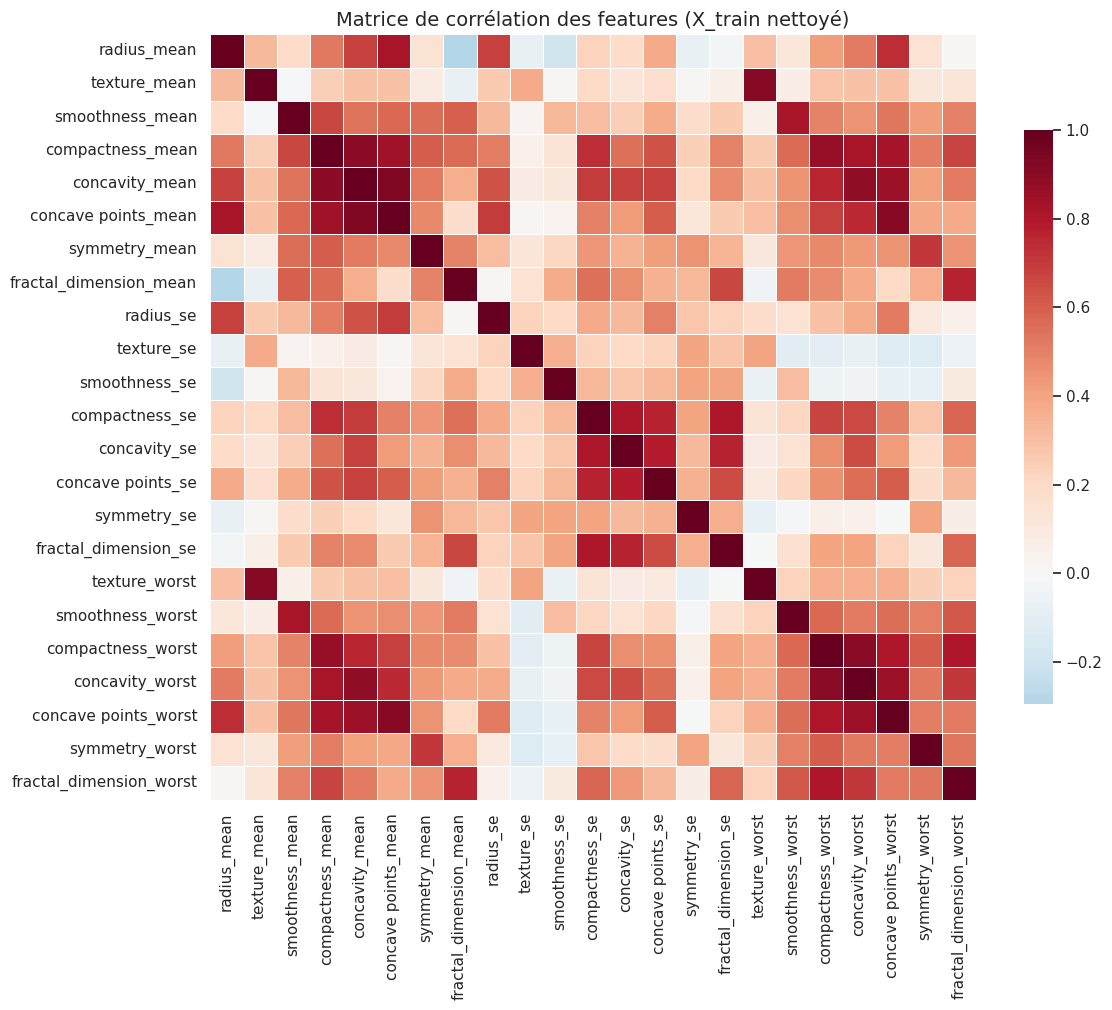

In [23]:
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix_cleaned, cmap='RdBu_r', center=0,
            annot=False, fmt=".2f", square=True,
            linewidths=0.5, cbar_kws={"shrink": 0.75})
plt.title("Matrice de corrélation des features (X_train nettoyé)", fontsize=14)
plt.tight_layout()
plt.show()

### Analyse de la matrice de corrélation (X_train nettoyé)

Après avoir supprimé les variables les plus corrélées (corr > 0.95), on observe que :
- La majorité des corrélations extrêmes ont disparu 
- Il subsiste encore quelques groupes de variables corrélées

**Décision :**
Plutôt que de supprimer davantage de variables (et risquer une perte d'information), on choisit de **conserver les features restantes**, car :

- La **PCA** (prévue plus tard) permettra de compresser la redondance automatiquement.
- Une éventuelle **sélection par Boruta** filtrera les features non pertinentes.
- Cela garantit une **meilleure couverture de la variance totale du dataset**.

## 4. Prétraitement & features <a id='preproc'></a>

### Sélection de variables avec Boruta

#### Scaler les données

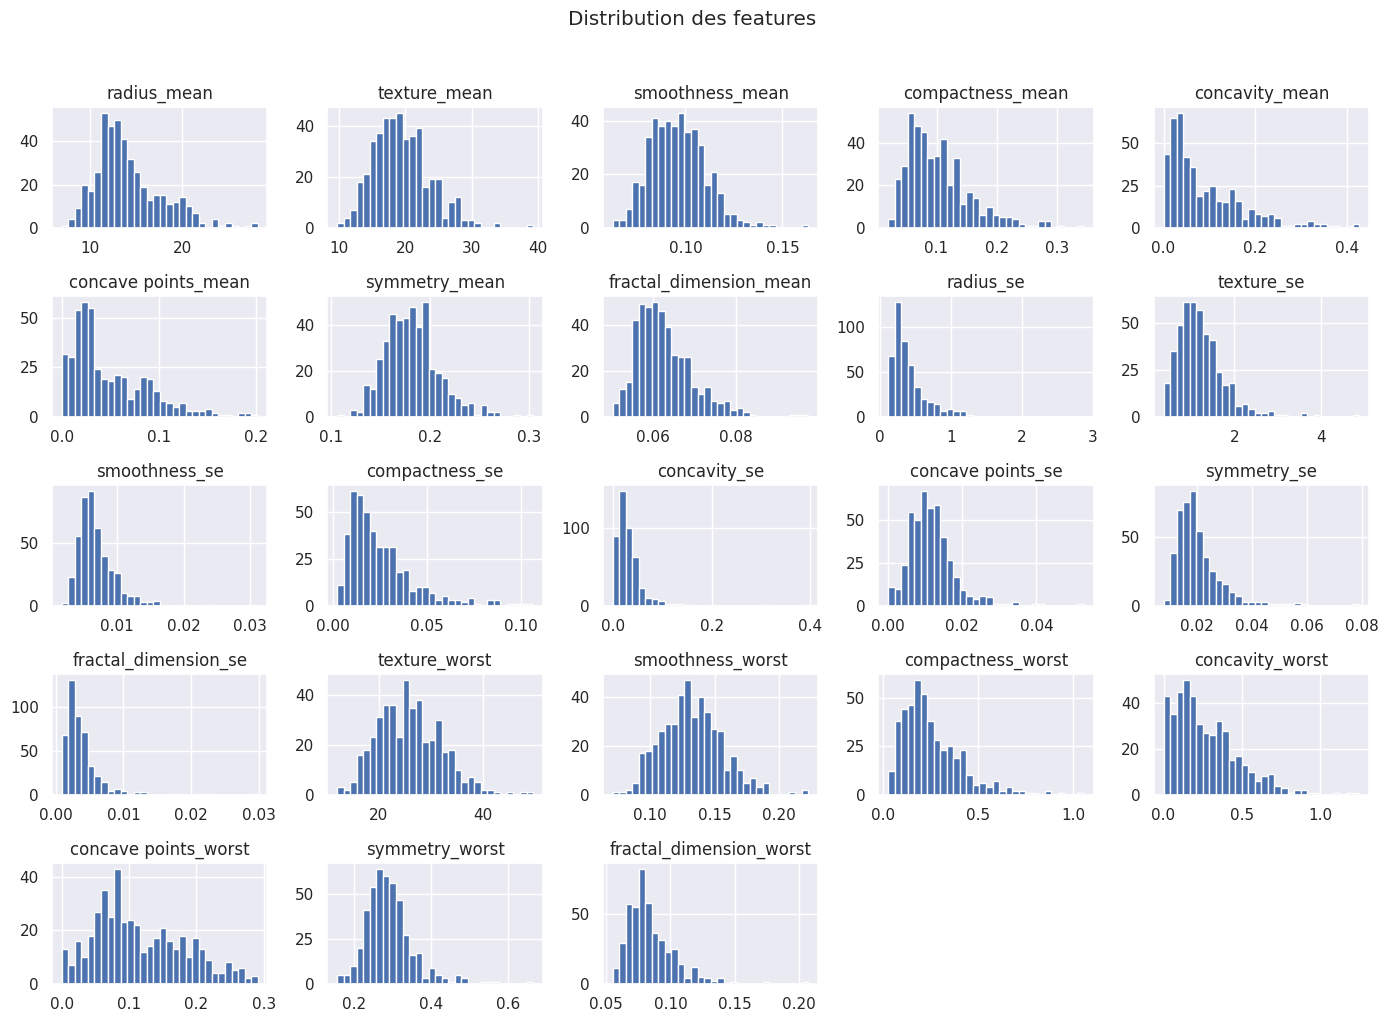

In [24]:
# Visualisation des distributions des variables
_ = X_train.hist(figsize=(14, 10), bins=30)
plt.suptitle('Distribution des features', y=1.02)
plt.tight_layout()
plt.show()

In [25]:
# Boxplots des outliers
fig = sp.make_subplots(rows=6, cols=5, subplot_titles=X.columns.tolist())

for i, col in enumerate(X_train.columns):
    row, col_pos = divmod(i, 5)
    box = px.box(X_train, y=col)
    for trace in box.data:
        fig.add_trace(trace, row=row+1, col=col_pos+1)

fig.update_layout(height=2000, width=1000, title_text="Visualisation des outliers (boxplots)")
fig.show()

### Analyse des distributions & outliers

**Interprétation des distributions :**  
La plupart des variables présentent des **distributions asymétriques** avec des **valeurs extrêmes** (outliers). Peu de features suivent une distribution gaussienne.

**Choix de la méthode de standardisation :**  
Utilisation de **RobustScaler**, car il est **moins sensible aux outliers** et plus adapté aux **distributions non normales**, contrairement au StandardScaler.


In [26]:
# Application du RobustScaler
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled

array([[ 0.63431953,  0.78980892, -0.66666667, ..., -0.01275185,
         0.18518519,  0.21380309],
       [-0.24142012, -1.18471338,  0.38239757, ..., -0.07232849,
         0.00592593, -0.59749035],
       [-0.11597633,  0.44949955, -0.99797673, ..., -0.45896455,
        -0.4962963 ,  0.06853282],
       ...,
       [-0.08047337,  1.13375796, -0.58421851, ..., -0.42631982,
        -0.76592593, -0.82915058],
       [ 0.2035503 ,  0.2966333 , -0.29994942, ...,  0.33562867,
        -0.42814815, -0.07287645],
       [ 0.88047337,  0.38216561,  0.84269095, ...,  0.83346085,
        -0.2962963 , -0.19787645]])

In [27]:
X_train.columns

Index(['radius_mean', 'texture_mean', 'smoothness_mean', 'compactness_mean',
       'concavity_mean', 'concave points_mean', 'symmetry_mean',
       'fractal_dimension_mean', 'radius_se', 'texture_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'texture_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')

In [28]:
# Estimators à comparer
estimators = {
    # RandomForest et ExtraTrees, avec gestion du déséquilibre de classes
    "RandomForest": RandomForestClassifier(n_estimators=100, class_weight='balanced', n_jobs=-1, random_state=42),
    "ExtraTrees": ExtraTreesClassifier(n_estimators=100, class_weight='balanced', n_jobs=-1, random_state=42),
}

In [29]:
# Dictionnaire pour stocker les résultats
boruta_results = {}

for name, est in estimators.items():
    print(f" Boruta avec {name} ...")
    boruta = BorutaPy(estimator=est, n_estimators='auto', random_state=42, max_iter=100, verbose=0)
    boruta.fit(X_train_scaled, y_train)
    
    selected = X_train.columns[boruta.support_].tolist()
    boruta_results[name] = selected
    print(f" {name} → {len(selected)} features sélectionnées")

 Boruta avec RandomForest ...
 RandomForest → 19 features sélectionnées
 Boruta avec ExtraTrees ...
 ExtraTrees → 22 features sélectionnées


In [30]:
pd.DataFrame({
    "Estimateur": ["RandomForest", "ExtraTrees"],
    "Nb Features": [len(boruta_results["RandomForest"]), len(boruta_results["ExtraTrees"])]
})

,Estimateur,Nb Features
0,RandomForest,19
1,ExtraTrees,22


#### Choix de l'estimateur Boruta : RandomForest plutôt que ExtraTrees

Après comparaison des résultats de BorutaPy avec deux estimateurs (`RandomForestClassifier` et `ExtraTreesClassifier`), j'ai constaté que :

- RandomForest sélectionne **moins de variables** que ExtraTrees ;
- Il agit comme un **filtre plus conservateur**, privilégiant la **robustesse** à la quantité ;
- Cela est cohérent avec mon objectif de **réduction de dimension** via PCA, et d’entraînement d’un modèle sensible comme le **Perceptron** ;
- Moins de variables = **moins de bruit**, **meilleure généralisation**, et **PCA plus efficace**.

J’ai donc choisi de **conserver uniquement les features sélectionnées par Boruta avec RandomForest**.

In [31]:
selected_features = boruta_results["RandomForest"]
selected_features

['radius_mean',
 'texture_mean',
 'smoothness_mean',
 'compactness_mean',
 'concavity_mean',
 'concave points_mean',
 'fractal_dimension_mean',
 'radius_se',
 'compactness_se',
 'concavity_se',
 'concave points_se',
 'symmetry_se',
 'fractal_dimension_se',
 'texture_worst',
 'smoothness_worst',
 'compactness_worst',
 'concavity_worst',
 'concave points_worst',
 'symmetry_worst']

In [32]:
X_train.shape[1]

23

In [33]:
# 1. Créer X_train et X_test filtrés avec ces colonnes
X_train_boruta = X_train[selected_features]
X_test_boruta = X_test[selected_features]

In [34]:
# Appliquer le scaling uniquement sur ces colonnes filtrées
scaler = RobustScaler()

X_train_boruta_scaled = pd.DataFrame(
    scaler.fit_transform(X_train_boruta),
    columns=selected_features,
    index=X_train_boruta.index
)
X_test_boruta_scaled = pd.DataFrame(
    scaler.transform(X_test_boruta),
    columns=selected_features,
    index=X_test_boruta.index
)

In [35]:
X_train_boruta_scaled.shape[1]

19

## 5. Réduction de dimension (PCA) <a id='pca'></a>

In [36]:
pca = PCA()
X_train_pca = pca.fit_transform(X_train_boruta_scaled)
X_test_pca = pca.transform(X_test_boruta_scaled)

In [37]:
# Visualisation de la variance expliquée
explained_var = pca.explained_variance_ratio_
cumulative_var = np.cumsum(explained_var)
optimal_components = np.argmax(cumulative_var >= 0.95) + 1

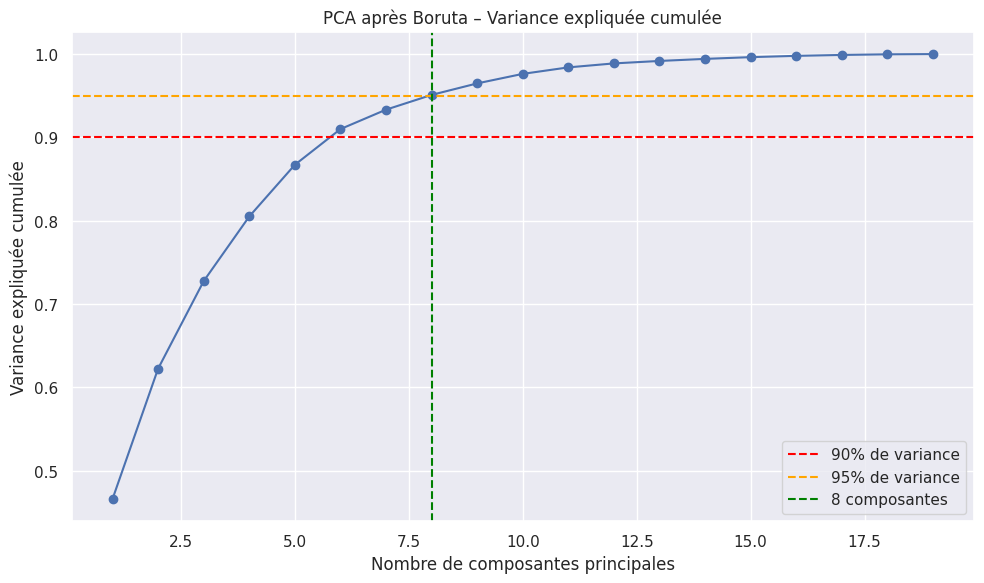

In [38]:
plt.figure(figsize=(10,6))
plt.plot(range(1, len(cumulative_var)+1), cumulative_var, marker='o')
plt.axhline(0.90, color='red', linestyle='--', label='90% de variance')
plt.axhline(0.95, color='orange', linestyle='--', label='95% de variance')
plt.axvline(optimal_components, color='green', linestyle='--', label=f'{optimal_components} composantes')
plt.title("PCA après Boruta – Variance expliquée cumulée")
plt.xlabel("Nombre de composantes principales")
plt.ylabel("Variance expliquée cumulée")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

#### Choix du nombre optimal de composantes PCA

Le graphique ci-dessus montre la variance expliquée cumulée par les composantes principales issues de la PCA appliquée après sélection des variables par Boruta.

- Le **seuil de 95 % de variance expliquée** est franchi avec **8 composantes principales**.
- Au-delà de ce point, l’ajout de nouvelles composantes n’apporte que très peu d'information supplémentaire (effet de saturation).
- Ce seuil constitue un **compromis optimal** entre compression et conservation de l'information utile.

**Je conserve donc uniquement les 8 premières composantes** comme nouvel espace de travail pour l'entraînement du modèle.


In [39]:
# Extraction finale des datasets PCA réduits 
X_train_pca = pd.DataFrame(X_train_pca[:, :optimal_components],
                           columns=[f"PCA_{i+1}" for i in range(optimal_components)],
                           index=X_train.index)

X_test_pca = pd.DataFrame(X_test_pca[:, :optimal_components],
                          columns=[f"PCA_{i+1}" for i in range(optimal_components)],
                          index=X_test.index)

print(f" PCA appliquée sur les features Boruta.\n {optimal_components} composantes retenues.")

 PCA appliquée sur les features Boruta.
 8 composantes retenues.


In [40]:
X_train_pca.head()

,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8
10,-1.695399,-1.007153,0.473299,-0.431327,1.040439,-0.243859,-0.147967,0.293575
170,-1.763745,0.410304,-0.393949,0.527610,-1.456400,0.496700,0.594428,-0.349746
407,0.355903,2.061318,1.799802,-0.155761,1.054650,-0.108205,-0.881854,0.159674
430,4.642235,-0.035857,-0.884065,-2.463096,-0.016282,0.991019,-0.373723,-0.956718
27,1.474421,-0.780902,2.114235,0.270925,-0.386206,-0.183061,0.533134,0.004054


## 6. Implémentation / Import de la classe `Perceptron` (OO) <a id='class'></a>

[Époque 1/30] Erreurs : 29 (patience=0)
[Époque 2/30] Erreurs : 18 (patience=0)
[Époque 3/30] Erreurs : 22 (patience=1)
[Époque 4/30] Erreurs : 21 (patience=2)
[Époque 5/30] Erreurs : 23 (patience=3)
[Époque 6/30] Erreurs : 15 (patience=0)
[Époque 7/30] Erreurs : 14 (patience=0)
[Époque 8/30] Erreurs : 21 (patience=1)
[Époque 9/30] Erreurs : 15 (patience=2)
[Époque 10/30] Erreurs : 12 (patience=0)
[Époque 11/30] Erreurs : 21 (patience=1)
[Époque 12/30] Erreurs : 19 (patience=2)
[Époque 13/30] Erreurs : 18 (patience=3)
[Époque 14/30] Erreurs : 15 (patience=4)
[Époque 15/30] Erreurs : 11 (patience=0)
[Époque 16/30] Erreurs : 19 (patience=1)
[Époque 17/30] Erreurs : 18 (patience=2)
[Époque 18/30] Erreurs : 16 (patience=3)
[Époque 19/30] Erreurs : 16 (patience=4)
[Époque 20/30] Erreurs : 16 (patience=5)
[Époque 21/30] Erreurs : 19 (patience=6)
[Époque 22/30] Erreurs : 16 (patience=7)
[Époque 23/30] Erreurs : 16 (patience=8)
[Époque 24/30] Erreurs : 18 (patience=9)
[Époque 25/30] Erreurs : 

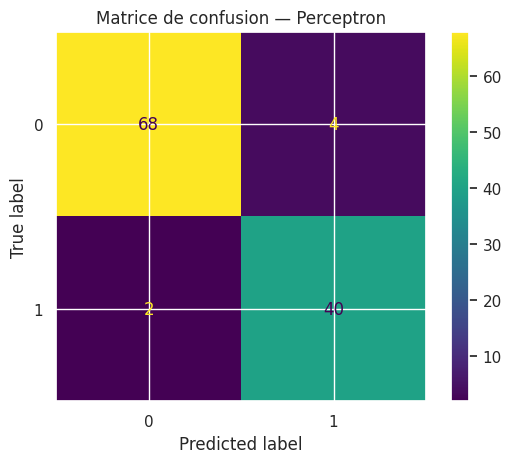

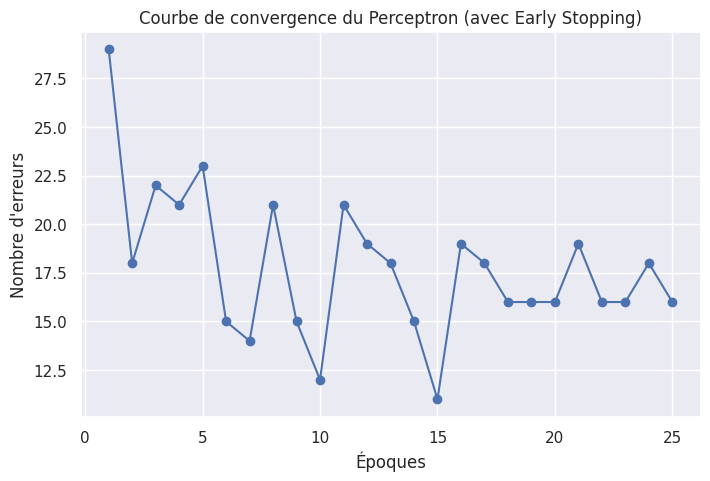

In [70]:
# Initialisation
percep = Perceptron(learning_rate=0.01, n_iter=30, verbose=True)

# Entraînement sur données PCA
percep.fit(X_train_pca.values, y_train.values)

# Prédiction
y_pred = percep.predict(X_test_pca.values)

# Évaluation
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("Matrice de confusion — Perceptron")
plt.show()

# Visualisation convergence
percep.plot_errors()


[Époque 1/500] Erreurs : 34 (patience=0)
[Époque 2/500] Erreurs : 17 (patience=0)
[Époque 3/500] Erreurs : 14 (patience=0)
[Époque 4/500] Erreurs : 20 (patience=1)
[Époque 5/500] Erreurs : 19 (patience=2)
[Époque 6/500] Erreurs : 13 (patience=0)
[Époque 7/500] Erreurs : 11 (patience=0)
[Époque 8/500] Erreurs : 18 (patience=1)
[Époque 9/500] Erreurs : 17 (patience=2)
[Époque 10/500] Erreurs : 17 (patience=3)
[Époque 11/500] Erreurs : 11 (patience=4)
[Époque 12/500] Erreurs : 20 (patience=5)
[Époque 13/500] Erreurs : 20 (patience=6)
[Époque 14/500] Erreurs : 16 (patience=7)
[Époque 15/500] Erreurs : 13 (patience=8)
[Époque 16/500] Erreurs : 22 (patience=9)
[Époque 17/500] Erreurs : 13 (patience=10)
Arrêt anticipé à l'époque 17 (aucune amélioration depuis 10 époques).
              precision    recall  f1-score   support

           0       0.97      0.96      0.97        72
           1       0.93      0.95      0.94        42

    accuracy                           0.96       114
   mac

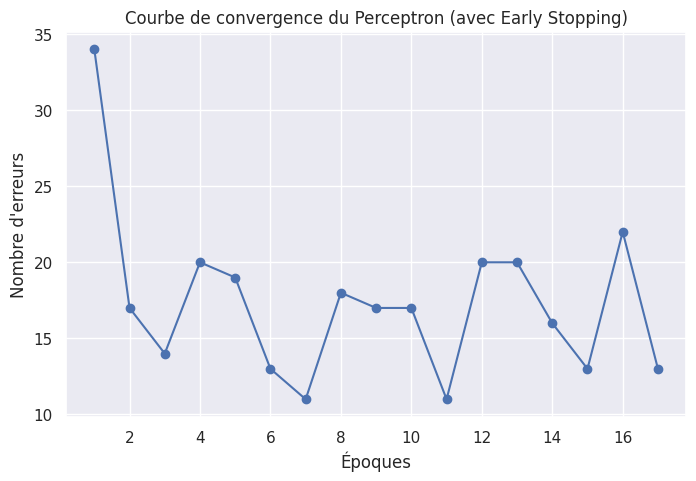

In [71]:
percep_v2 = PerceptronEarlyStopping(learning_rate=0.01, n_iter=500, patience=10, shuffle=True, verbose=True)
percep_v2.fit(X_train_pca.values, y_train.values)

y_pred_v2 = percep_v2.predict(X_test_pca.values)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_v2))

percep_v2.plot_errors()


#### Perceptron sklearn (référence)

Classification Report (scikit-learn):
              precision    recall  f1-score   support

           0       0.96      0.96      0.96        72
           1       0.93      0.93      0.93        42

    accuracy                           0.95       114
   macro avg       0.94      0.94      0.94       114
weighted avg       0.95      0.95      0.95       114



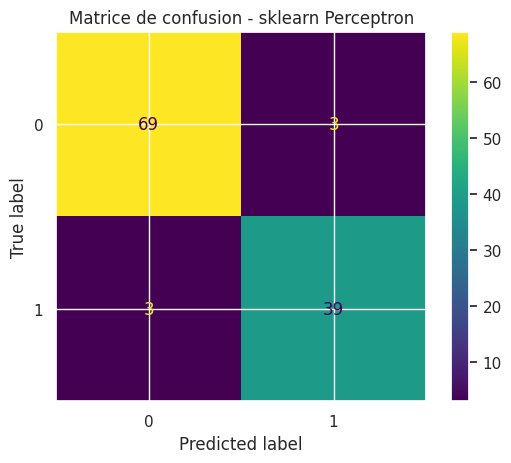

In [72]:
from sklearn.linear_model import Perceptron

sklearn_perceptron = Perceptron(penalty=None, max_iter=1000, alpha=0.0001)
sklearn_perceptron.fit(X_train_pca, y_train)
y_pred_sk = sklearn_perceptron.predict(X_test_pca)

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

print("Classification Report (scikit-learn):")
print(classification_report(y_test, y_pred_sk))
ConfusionMatrixDisplay.from_estimator(sklearn_perceptron, X_test_pca, y_test)
plt.title("Matrice de confusion - sklearn Perceptron")
plt.show()


Classification Report (Logistic Regression):
              precision    recall  f1-score   support

           0       0.96      0.99      0.97        72
           1       0.97      0.93      0.95        42

    accuracy                           0.96       114
   macro avg       0.97      0.96      0.96       114
weighted avg       0.97      0.96      0.96       114



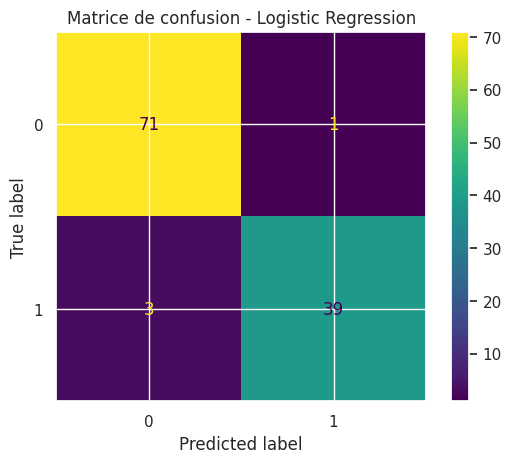

In [73]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(X_train_pca, y_train)
y_pred_log = logreg.predict(X_test_pca)

print("Classification Report (Logistic Regression):")
print(classification_report(y_test, y_pred_log))
ConfusionMatrixDisplay.from_estimator(logreg, X_test_pca, y_test)
plt.title("Matrice de confusion - Logistic Regression")
plt.show()


Classification Report (MLP):
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        72
           1       1.00      0.93      0.96        42

    accuracy                           0.97       114
   macro avg       0.98      0.96      0.97       114
weighted avg       0.97      0.97      0.97       114



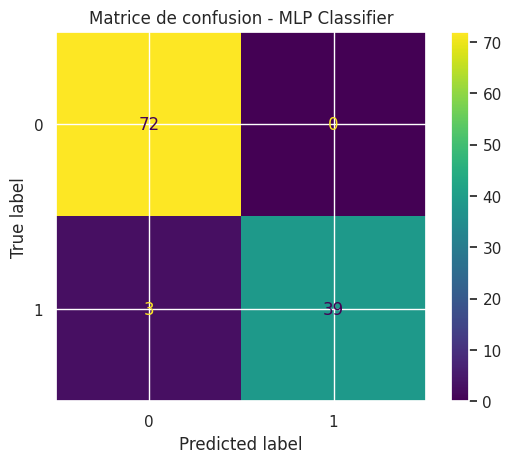

In [74]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(50,), activation='relu', max_iter=500)
mlp.fit(X_train_pca, y_train)
y_pred_mlp = mlp.predict(X_test_pca)

print("Classification Report (MLP):")
print(classification_report(y_test, y_pred_mlp))
ConfusionMatrixDisplay.from_estimator(mlp, X_test_pca, y_test)
plt.title("Matrice de confusion - MLP Classifier")
plt.show()


Classification Report (SVC):
              precision    recall  f1-score   support

           0       0.96      0.97      0.97        72
           1       0.95      0.93      0.94        42

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114



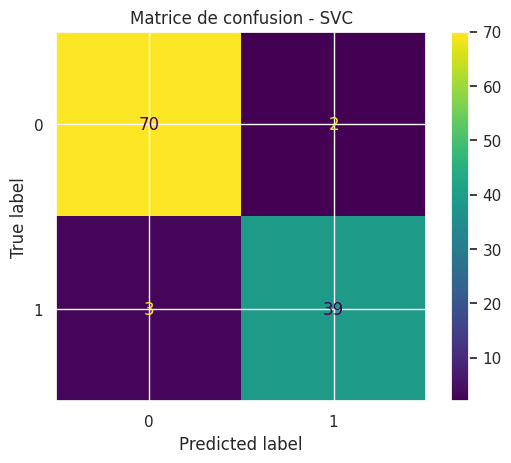

In [75]:
from sklearn.svm import SVC

svc = SVC(kernel='linear', C=1.0)
svc.fit(X_train_pca, y_train)
y_pred_svc = svc.predict(X_test_pca)

print("Classification Report (SVC):")
print(classification_report(y_test, y_pred_svc))
ConfusionMatrixDisplay.from_estimator(svc, X_test_pca, y_test)
plt.title("Matrice de confusion - SVC")
plt.show()


In [77]:
from sklearn.metrics import f1_score, accuracy_score

models = {
    "Custom Perceptron": y_pred,
    "PerceptronEStopping": y_pred_v2,
    "Sklearn Perceptron": y_pred_sk,
    "Logistic Regression": y_pred_log,
    "MLP": y_pred_mlp,
    "SVC": y_pred_svc
}

print("🔎 Tableau comparatif des F1-scores et Accuracy :\n")
for name, y_pred in models.items():
    f1 = f1_score(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    print(f"{name:<20} | F1-score: {f1:.4f} | Accuracy: {acc:.4f}")


🔎 Tableau comparatif des F1-scores et Accuracy :

Custom Perceptron    | F1-score: 0.9398 | Accuracy: 0.9561
PerceptronEStopping  | F1-score: 0.9412 | Accuracy: 0.9561
Sklearn Perceptron   | F1-score: 0.9286 | Accuracy: 0.9474
Logistic Regression  | F1-score: 0.9512 | Accuracy: 0.9649
MLP                  | F1-score: 0.9630 | Accuracy: 0.9737
SVC                  | F1-score: 0.9398 | Accuracy: 0.9561


In [ ]:
activations = ['step', 'sigmoid', 'tanh', 'relu']
results = []

for act in activations:
    print(f"Entraînement avec activation: {act}")
    model = Perceptron(activation=act, verbose=False)
    model.fit(X_train_pca, y_train)
    y_pred = model.predict(X_test_pca)
    results.append({
        "Activation": act,
        "Accuracy": accuracy_score(y_test, y_pred),
        "F1-score": f1_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "Balanced Accuracy": balanced_accuracy_score(y_test, y_pred)
    })


Entraînement avec activation: sigmoid


TypeError: Perceptron.__init__() got an unexpected keyword argument 'activation'

## 7. Baselines & Pipeline Scikit-learn <a id='pipeline'></a>

## 8. Entraînement, Métriques & Visualisations <a id='metrics'></a>

## 9. Validation croisée & courbes ROC/PR <a id='cv'></a>

## 10. Sauvegardes (modèle, figures) <a id='save'></a>

## 11. Robustesse & tests complémentaires <a id='robust'></a>

#### Choix de l'estimateur pour Boruta avant PCA

Dans le cadre de ce projet, j'ai utilisé BorutaPy avec deux estimateurs différents — `RandomForestClassifier` et `ExtraTreesClassifier` — afin de sélectionner les variables les plus pertinentes pour la prédiction du diagnostic (bénin ou malin).

Après comparaison :

- `RandomForest` a sélectionné 19 variables
- `ExtraTrees` a sélectionné 22 variables
- L’intersection des deux donnait 17 variables communes
- L’union des deux donnait 24 variables distinctes

##### Choix retenu : **Union (RandomForest ∪ ExtraTrees)**

J’ai volontairement choisi d’utiliser **l’union des deux estimateurs** pour la suite du traitement, car :

- Mon objectif est de procéder ensuite à une **réduction de dimension via PCA (Analyse en Composantes Principales)** ;
- PCA est une méthode **capable de compresser les redondances entre variables** tout en conservant l'information globale ;
- En conservant **plus de features pertinentes**, je maximise la **quantité d'information** transmise à la PCA ;
- Les éventuelles corrélations ou variables partiellement redondantes seront **traitées naturellement par les composantes principales**.

> Ainsi, ce choix permet de **préserver un maximum de diversité informative** avant transformation, tout en s'appuyant sur une double validation croisée par deux estimateurs robustes.

---

**Étape suivante →** Réduction de dimension avec PCA pour visualiser et optimiser l’espace de représentation des données.
